In [1]:
import sys
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm

from numpy import log, exp
from datetime import datetime as dt
from datetime import timedelta as td
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import macrodata as md
# from _aux.dateFunctions import EoMonth, eDate


In [2]:
sec = json.load(open('macrodata/data_specs.json'))

In [3]:
pd.DataFrame({x:sec[x] for x in sec if (sec[x]['region'] == 'US') and (sec[x]['asset_class'] == 'Inflation')})

,us_cpi,us_cpi_core,us_cpi_food,us_cpi_energy,us_cpi_gasoline,us_cpi_medicare,us_cpi_shelter,us_cpi_rent_sa
description,US CPI Index level,US CPI Core Index level,US CPI Food Index level,US CPI Energy Index level,US CPI Gasoline Index level,US CPI Medicare Index level,US CPI Shelter Index level,US CPI Rent Index level
asset_class,Inflation,Inflation,Inflation,Inflation,Inflation,Inflation,Inflation,Inflation
sub_asset_class,Inflation,cpi_core,cpi_food,cpi_energy,cpi_others,cpi_others,cpi_others,cpi_others
region,US,US,US,US,US,US,US,US
source,"{'name': 'bls', 'kwargs': {'code': 'CUUR0000SA...","{'name': 'bls', 'kwargs': {'code': 'CUUR0000SA...","{'name': 'bls', 'kwargs': {'code': 'CUUR0000SA...","{'name': 'bls', 'kwargs': {'code': 'CUUR0000SA...","{'name': 'bls', 'kwargs': {'code': 'CUUR0000SE...","{'name': 'bls', 'kwargs': {'code': 'CUUR0000SA...","{'name': 'bls', 'kwargs': {'code': 'CUUR0000SA...","{'name': 'bls', 'kwargs': {'code': 'CUSR0000SE..."
frequency,[m],[m],[m],[m],[m],[m],[m],[m]
transform,y,y,y,y,y,y,y,y


In [5]:
sel_sec = {x:sec[x] for x in sec if (sec[x]['region'] == 'US') and (sec[x]['asset_class'] == 'Inflation')}

In [6]:
db = md.Database(sel_sec, 'm').data

Retrieving data from BLS - Bureau of Labour Statistics...


In [8]:
us_cpi = db[['us_cpi', 'us_cpi_core', 'us_cpi_food',
             'us_cpi_medicare', 'us_cpi_shelter',
             'us_cpi_rent_sa']].astype(float)
us_cpi_high = db[['us_cpi_energy', 'us_cpi_gasoline']].astype(float)

In [9]:
us_cpi_YoY = us_cpi.dropna().apply(lambda x : log(x), axis = 1).diff(periods = 12).dropna()
us_cpi_high_YoY = us_cpi_high.apply(lambda x : log(x), axis = 1).diff(periods = 12).dropna()
us_cpi_MoM = us_cpi.dropna().apply(lambda x : log(x), axis = 1).diff(periods = 1).dropna()
us_cpi_high_MoM = us_cpi_high.apply(lambda x : log(x), axis = 1).diff(periods = 1).dropna()

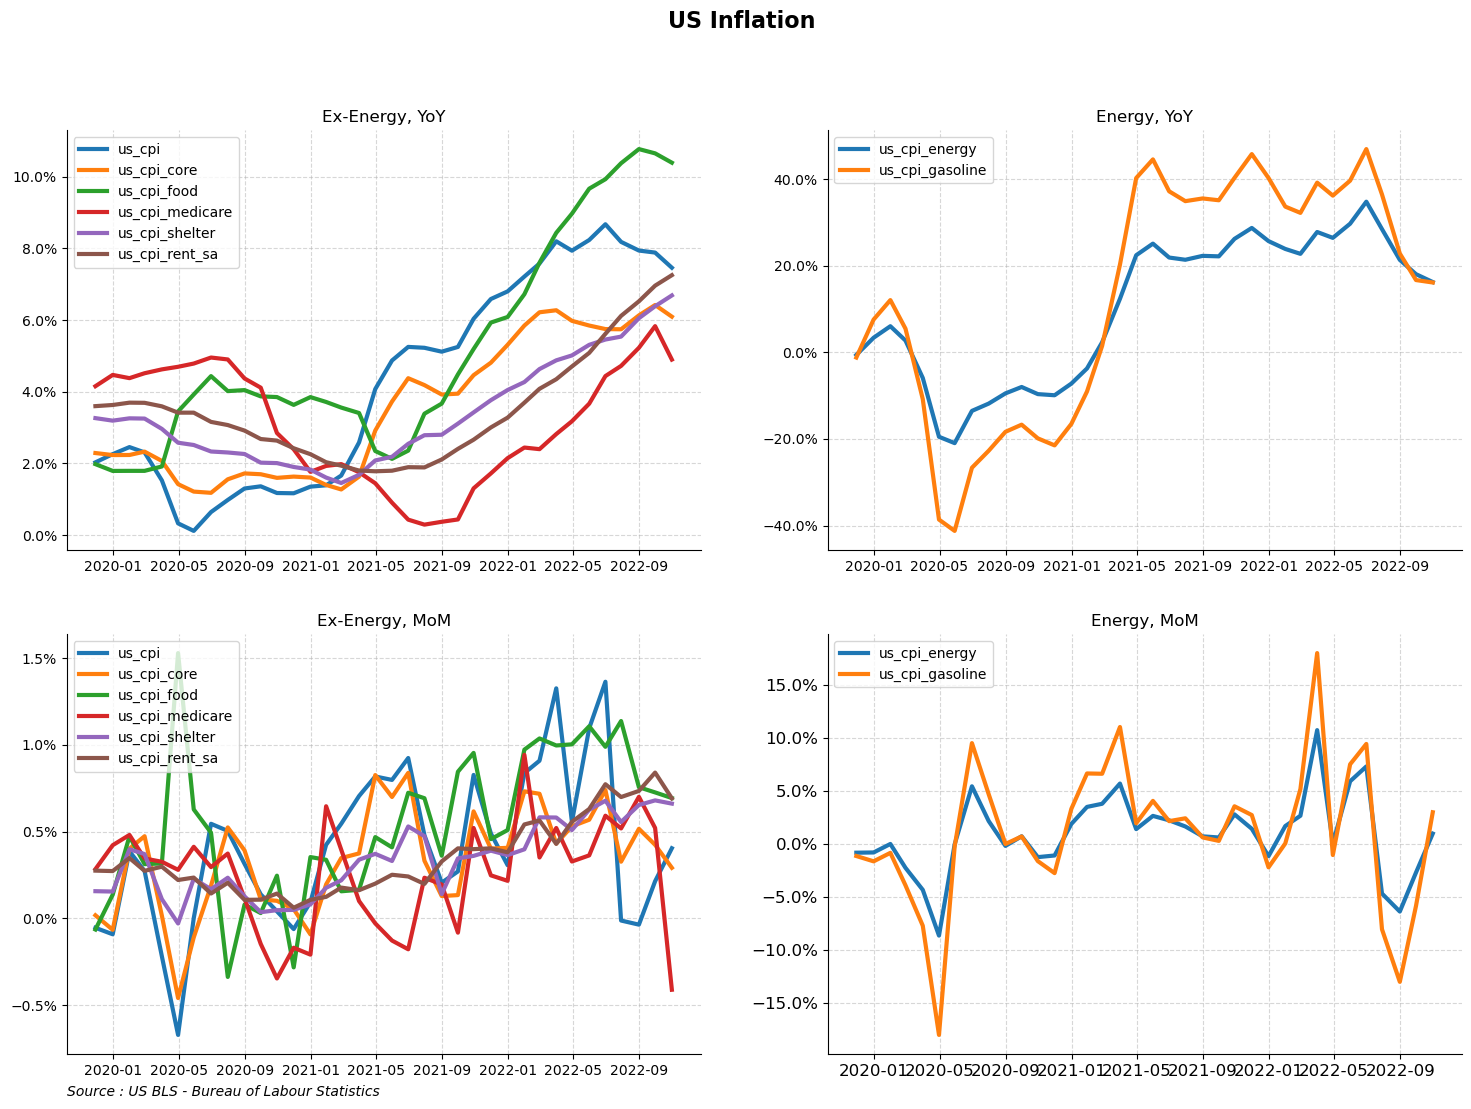

In [11]:
f, ax = plt.subplots(2,2, figsize=(18,12))
f.suptitle('US Inflation', fontsize = 16, fontweight = 'bold')

(us_cpi_YoY.iloc[-36:] * 100).plot(ax = ax[0, 0], lw = 3, title = 'Ex-Energy, YoY')
(us_cpi_high_YoY.iloc[-36:] * 100).plot(ax = ax[0, 1], lw = 3, title = 'Energy, YoY')
(us_cpi_MoM.iloc[-36:] * 100).plot(ax = ax[1, 0], lw = 3, title = 'Ex-Energy, MoM')
(us_cpi_high_MoM.iloc[-36:] * 100).plot(ax = ax[1, 1], lw = 3, title = 'Energy, MoM')

for a in ax.reshape(1,4)[0] :
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 1))
    a.grid(alpha = 0.5, ls = '--')

void = plt.xticks(fontsize=12)
void = plt.yticks(fontsize=12)

void = ax[1, 0].text(0, -0.1, 'Source : US BLS - Bureau of Labour Statistics',
              fontstyle = 'italic',
              transform = ax[1, 0].transAxes)

# plt.savefig('../_data/figs/USInflation.jpg')

In [94]:
l = ['us_ism_manufacturing', 'us_cpi', 'us_michigan_cons_conf']
sel_sec = {x:sec[x] for x in l}

In [95]:
m_db = database(sel_sec, 1).data.astype(float)

Retrieving data from BLS - Bureau of Labour Statistics...
Retrieving data from FRED - FED St Louis Economic Data...


In [96]:
m_db['us_cpi'] = m_db['us_cpi'].map(log).diff()
m_db = m_db.iloc[-36:]

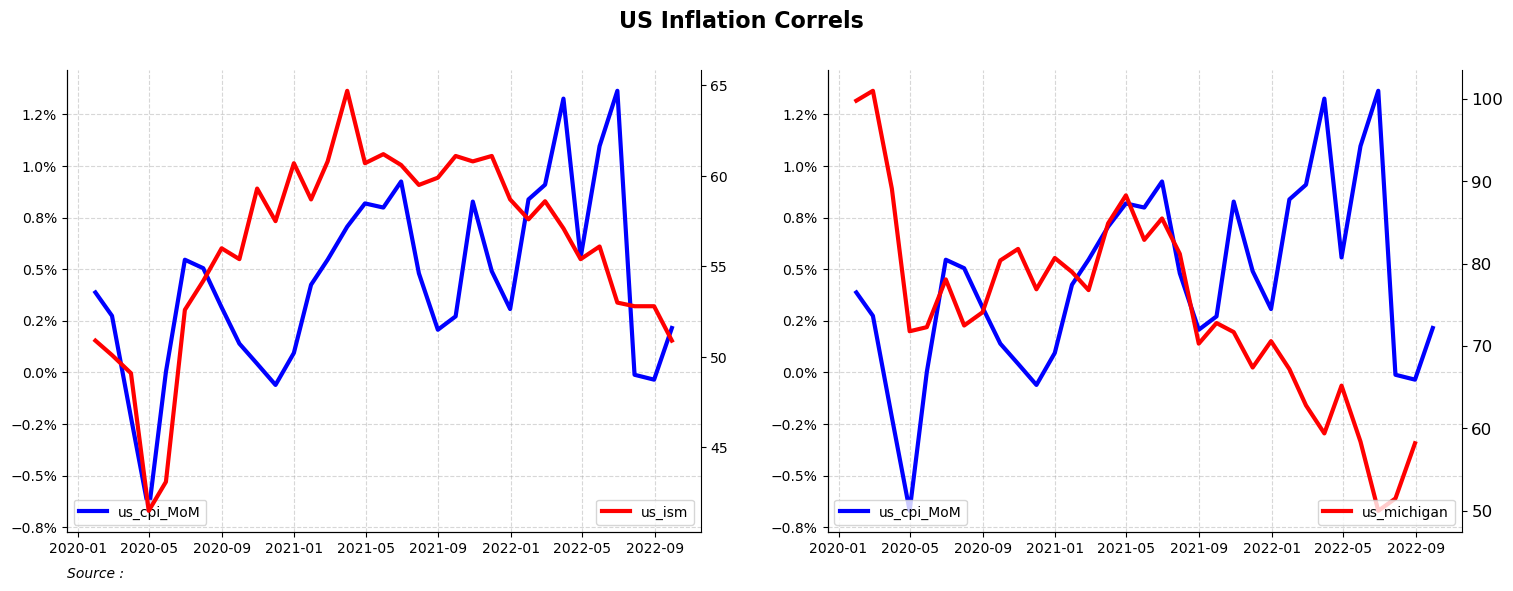

In [97]:
f, ax = plt.subplots(1, 2, figsize=(18,6))
f.suptitle('US Inflation Correls', fontsize = 16, fontweight = 'bold')

ax[0].plot(m_db.index, m_db['us_cpi'] * 100, color = 'blue', lw = 3, label = 'us_cpi_MoM')
ax2 = ax[0].twinx()
ax2.plot(m_db.index, m_db['us_ism_manufacturing'], color = 'red', lw = 3, label = 'us_ism')
ax[1].plot(m_db.index, m_db['us_cpi'] * 100, color = 'blue', lw = 3, label = 'us_cpi_MoM')
ax3 = ax[1].twinx()
ax3.plot(m_db.index, m_db['us_michigan_cons_conf'], color = 'red', lw = 3, label = 'us_michigan')

for a in ax :
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 1))
    a.grid(alpha = 0.5, ls = '--')
    a.legend(loc = 'lower left')
    
ax2.spines['top'].set_visible(False)
ax2.legend(loc = 'lower right')
ax3.spines['top'].set_visible(False)
ax3.legend(loc = 'lower right')

void = plt.xticks(fontsize=12)
void = plt.yticks(fontsize=12)

void = ax[0].text(0, -0.1, 'Source : ',
              fontstyle = 'italic',
              transform = ax[0].transAxes)

### Inflation Expectations

In [3]:
selection = ['us_5v5_inflation', 'us_5y_be_inflation', '^TNX']

In [4]:
sel_sec = {k:sec[k] for k in selection}

In [8]:
us_inflation_exp = database(sel_sec, 1).data.fillna(method = 'ffill')

Retrieving data from Yahoo Finance...
[*********************100%***********************]  1 of 1 completed
Retrieving data from FRED - FED St Louis Economic Data...


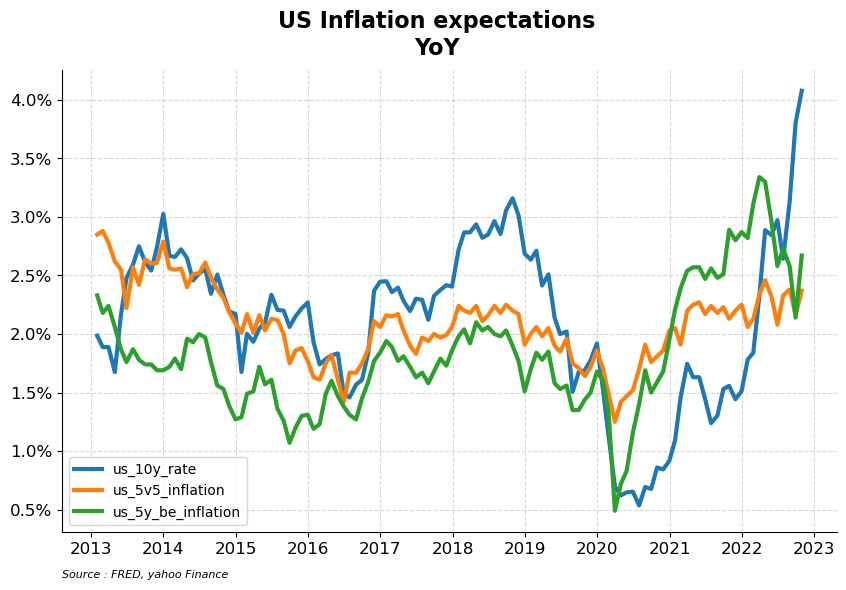

In [16]:
%matplotlib inline
f, ax = plt.subplots(figsize=(10,6))
f.suptitle('US Inflation expectations\nYoY', fontsize = 16, fontweight = 'bold')

us_inflation_exp.iloc[-120:-2].plot(ax = ax, lw = 3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha = 0.5, ls = '--')
ax.legend(loc = 'lower left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 1))

void = plt.xticks(fontsize=12)
void = plt.yticks(fontsize=12)

void = ax.text(0, -0.1, 'Source : FRED, yahoo Finance',
              fontstyle = 'italic',
              fontsize = 8,
              transform = ax.transAxes)

plt.savefig('../_data/figs/us_inf_exp.pdf')

# HOUSING

In [7]:
sec = json.load(open('../_data/data_specs.json'))

In [8]:
sel_sec = {x:sec[x] for x in sec if sec[x]['sub_asset_class'] == 'housing'}

In [10]:
m_db = database(sel_sec, 'm')

In [13]:
housing = m_db.data.apply(lambda x: log(x), axis = 1).diff().dropna()

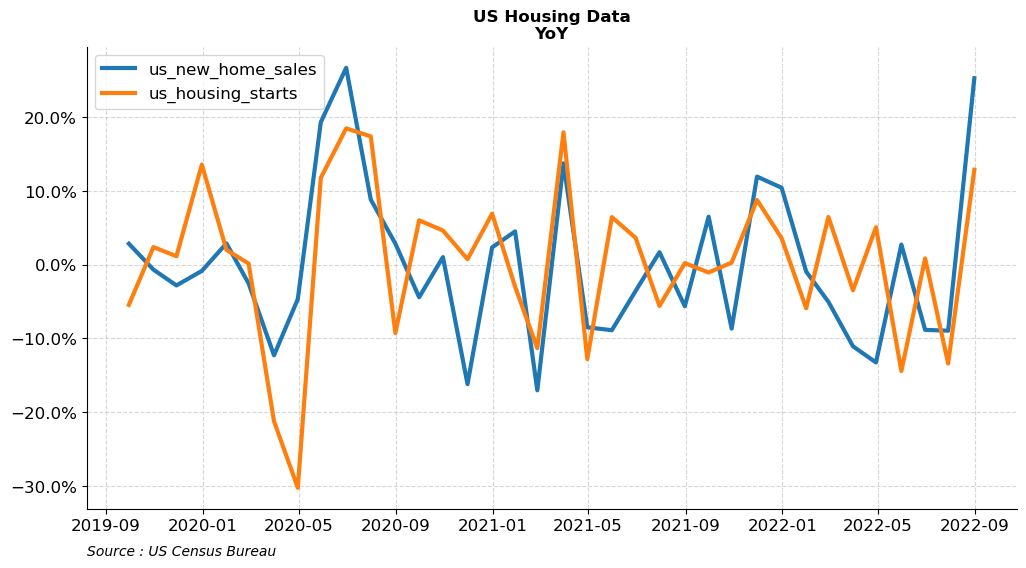

In [15]:
f, ax = plt.subplots(figsize = (12,6))

(housing.iloc[-36:] * 100).plot(ax = ax, lw = 3)

ax.grid(alpha = 0.5, ls = '--')
ax.set_title('US Housing Data\nYoY', fontweight = 'bold', fontsize = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 1))
ax.legend(fontsize = 12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
   
void = plt.xticks(fontsize=12)
void = plt.yticks(fontsize=12)
void = ax.text(0, -0.1, 'Source : US Census Bureau',
              fontstyle = 'italic',
              transform = ax.transAxes)

plt.savefig('us_housing.pdf')

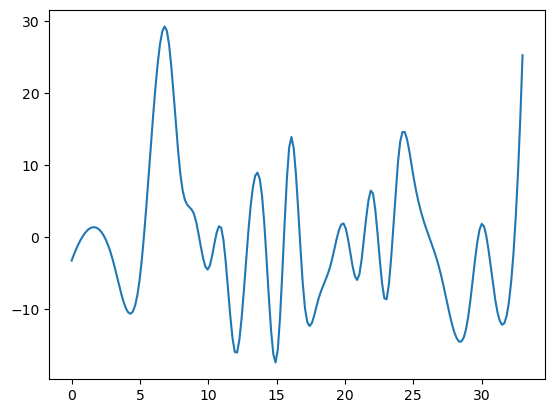

In [103]:
from scipy.interpolate import UnivariateSpline

x = np.array([x for x in range(34)])
y = np.array((housing.iloc[-36:-2] * 100)['us_new_home_sales'].values)
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = UnivariateSpline(x, y)

plt.plot(x_smooth, y_smooth(x_smooth))

In [101]:
y

array([ -2.84110018,  -0.86831226,   2.86552558,  -2.57524961,
       -12.32326404,  -4.69885094,  19.31447898,  26.69299861,
         8.81856692,   2.83915301,  -4.44078885,   1.0040245 ,
       -16.23426507,   2.32298483,   4.49009204, -17.07531641,
        13.72678928,  -8.52587089,  -8.91487309,  -3.57672239,
         1.66670525,  -5.66723871,   6.49028862,  -8.7011377 ,
        11.92722392,  10.41693303,  -0.95809116,  -5.05968494,
       -11.10022796, -13.29253932,   2.70932907,  -8.87281156,
        -8.98269584,  25.27753489])